In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.15.1


In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Data

In [6]:
df = pd.read_csv('../../data/human/2-player-UR.csv', index_col=False)
df.head()

Unnamed: 0 source     treatment       group  round           player  \
0           0  human  score + grid  Grupo-0001      1  405186428721292   
1           1  human  score + grid  Grupo-0001      1  728608683559397   
2           2  human  score + grid  Grupo-0001      2  405186428721292   
3           3  human  score + grid  Grupo-0001      2  728608683559397   
4           4  human  score + grid  Grupo-0001      3  405186428721292   

   choice  score  attendance  ac_score  
0       0      0           1        25  
1       1      1           1        25  
2       1      1           1        25  
3       0      0           1        25  
4       0      0           1        25

In [7]:
observed_decisions = pd.pivot_table(
	data=df,
	values=['choice'],
	columns=['player'],
	index='round'
).reset_index(drop=True)
#observed_decisions.columns = ['index', '']
print(observed_decisions.shape)
observed_decisions.head()

(50, 46)


choice                                                  \
player 13356387721893  60665347009372  61697837637039  83133970959175    
0                  1.0             1.0             1.0             0.0   
1                  1.0             1.0             0.0             0.0   
2                  1.0             0.0             0.0             0.0   
3                  1.0             1.0             1.0             0.0   
4                  1.0             1.0             1.0             0.0   

                                                                        \
player 117165631034112 193508520589663 196901325209443 245070533883063   
0                  1.0             1.0             0.0             1.0   
1                  0.0             1.0             1.0             1.0   
2                  1.0             0.0             0.0             1.0   
3                  1.0             1.0             1.0             0.0   
4                  1.0             1.0             1.0             0.0   

                                        ...                                  \
player 264457402264388 266424456379660  ... 806436351352675 808621019940568   
0                  1.0             0.0  ...             1.0             1.0   
1                  0.0             1.0  ...             1.0             0.0   
2                  1.0             1.0  ...             1.0             1.0   
3                  1.0             1.0  ...             1.0             1.0   
4                  1.0             0.0  ...             1.0             1.0   

                                                                        \
player 817293722184263 826599327153195 899884536554788 907597849867592   
0                  0.0             0.0             1.0             0.0   
1                  1.0             0.0             0.0             1.0   
2                  1.0             1.0             1.0             1.0   
3                  1.0             1.0             0.0             0.0   
4                  0.0             1.0             1.0             1.0   

                                                                        
player 911083385335064 918915269507625 921609061380903 958455151560277  
0                  0.0             1.0             1.0             1.0  
1                  1.0             1.0             1.0             0.0  
2                  1.0             1.0             1.0             1.0  
3                  0.0             0.0             0.0             1.0  
4                  0.0             0.0             1.0             0.0  

[5 rows x 46 columns]

In [8]:
# Players' decisions
observed_decisions = df[['choice', 'player']].values
# observed_decisions = df['choice'].values
# player_in_action = df['player'].values
observed_decisions

array([[              0, 405186428721292],
       [              1, 728608683559397],
       [              1, 405186428721292],
       ...,
       [              0, 727967798557118],
       [              1, 727967798557118],
       [              0, 405074693615800]])

In [6]:
# number of trials
n = df.groupby('player')['round'].max().reset_index()['round'].values
print(f'n={n}')
# Simulate outcome variable
k = df.groupby('player')['choice'].sum().reset_index().choice.values
print('')
print(f'k={k}')

n=[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50]

k=[36 41 26  1 29 13 33 26 28 28 20 28 36 25 31 25 24 29 29 32 24 30 34 35
 29 27 26 48 25 22 21 28 27 25 22 30 39 39 32 25 25 44 19 33 33 29]


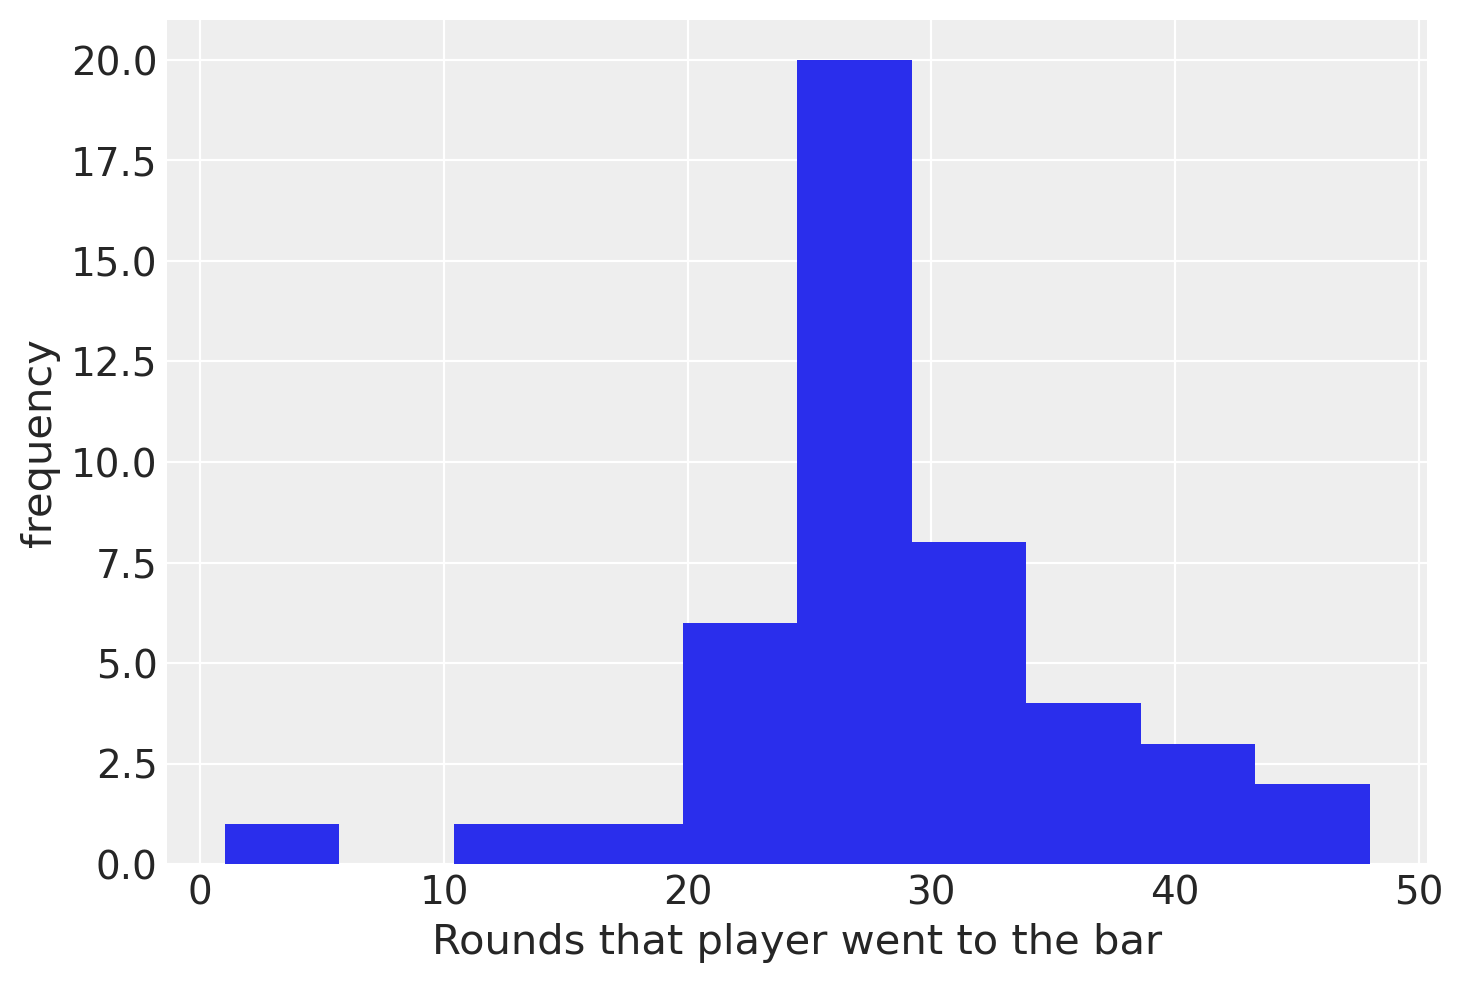

In [7]:
plt.hist(k)
plt.xlabel("Rounds that player went to the bar")
plt.ylabel("frequency");

## Unpooled Binomial Model

In [8]:
players = df['player'].unique().tolist()
coords = {
    "player": players
}

with pm.Model(coords=coords) as unpooled_model:
    # Priors for unknown model parameters
    theta = pm.Beta("theta", alpha=1, beta=1, dims="player")
    # Likelihood (sampling distribution) of observations
    k_obs = pm.Binomial("k_obs", p=theta, n=n, observed=k)

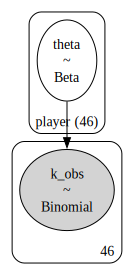

In [9]:
pm.model_to_graphviz(unpooled_model)

In [10]:
with unpooled_model:
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [k_obs, theta]


In [46]:
with unpooled_model:
    idata = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

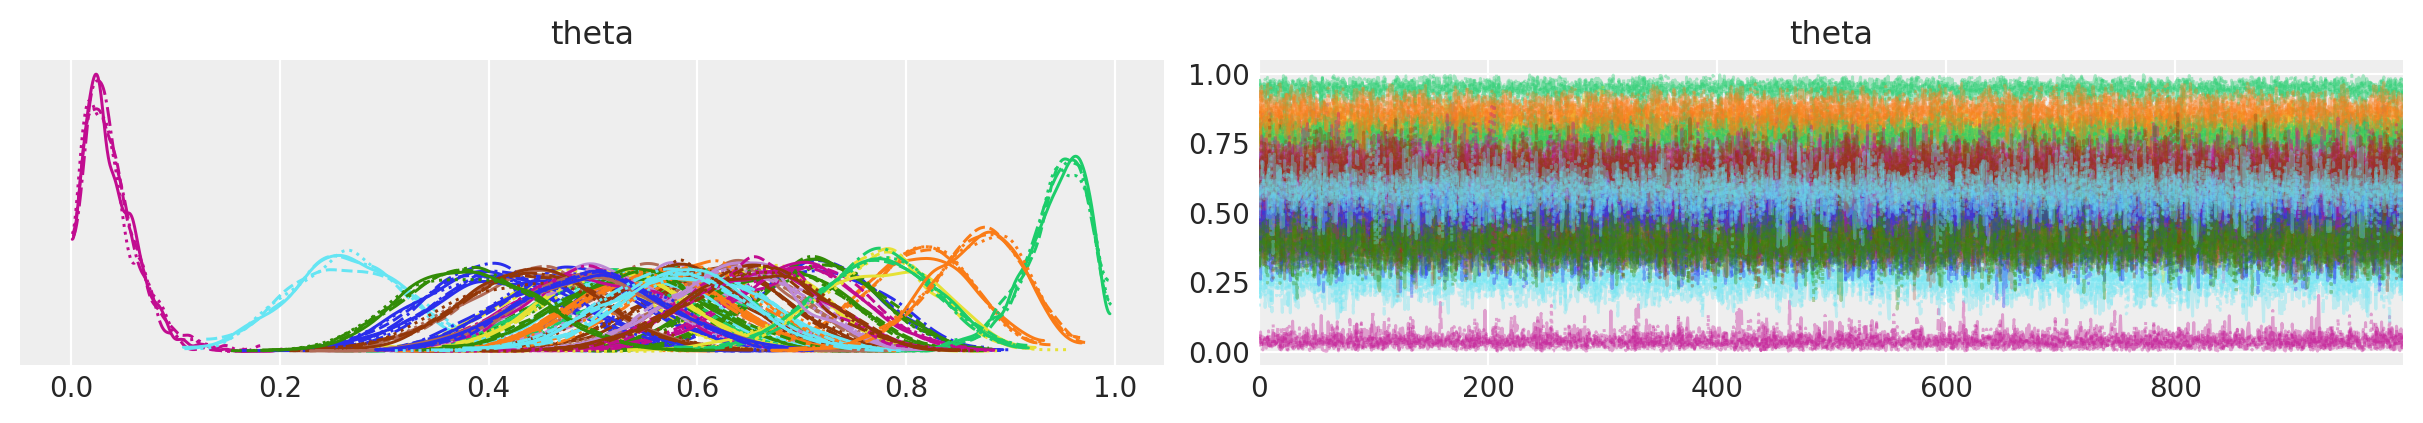

In [47]:
az.plot_trace(idata)

---

## Hierarchical Binomial Model

In [71]:
players = df['player'].unique().tolist()
coords = {
    "player": players
}
threshold = 0.5

with pm.Model(coords=coords) as hierarchical_model:
    # Priors
    mu_a = pm.Normal("mu_a", mu=threshold, sigma=1)
    sigma_a = pm.Exponential("sigma_a", 1)
    # Random thetas
    theta = pm.TruncatedNormal(
        "theta", 
        mu=mu_a, 
        sigma=sigma_a, 
        lower=0,
        upper=1,
        dims="player"
    )
    # Likelihood (sampling distribution) of observations
    k_obs = pm.Binomial("k_obs", p=theta, n=n, observed=k)


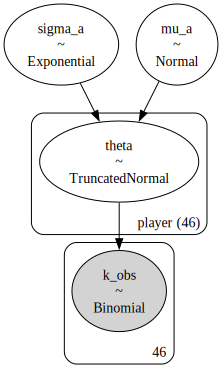

In [72]:
pm.model_to_graphviz(hierarchical_model)

In [73]:
with hierarchical_model:
    idata = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, theta]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.


array([[<Axes: title={'center': 'mu_a'}>,
        <Axes: title={'center': 'mu_a'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

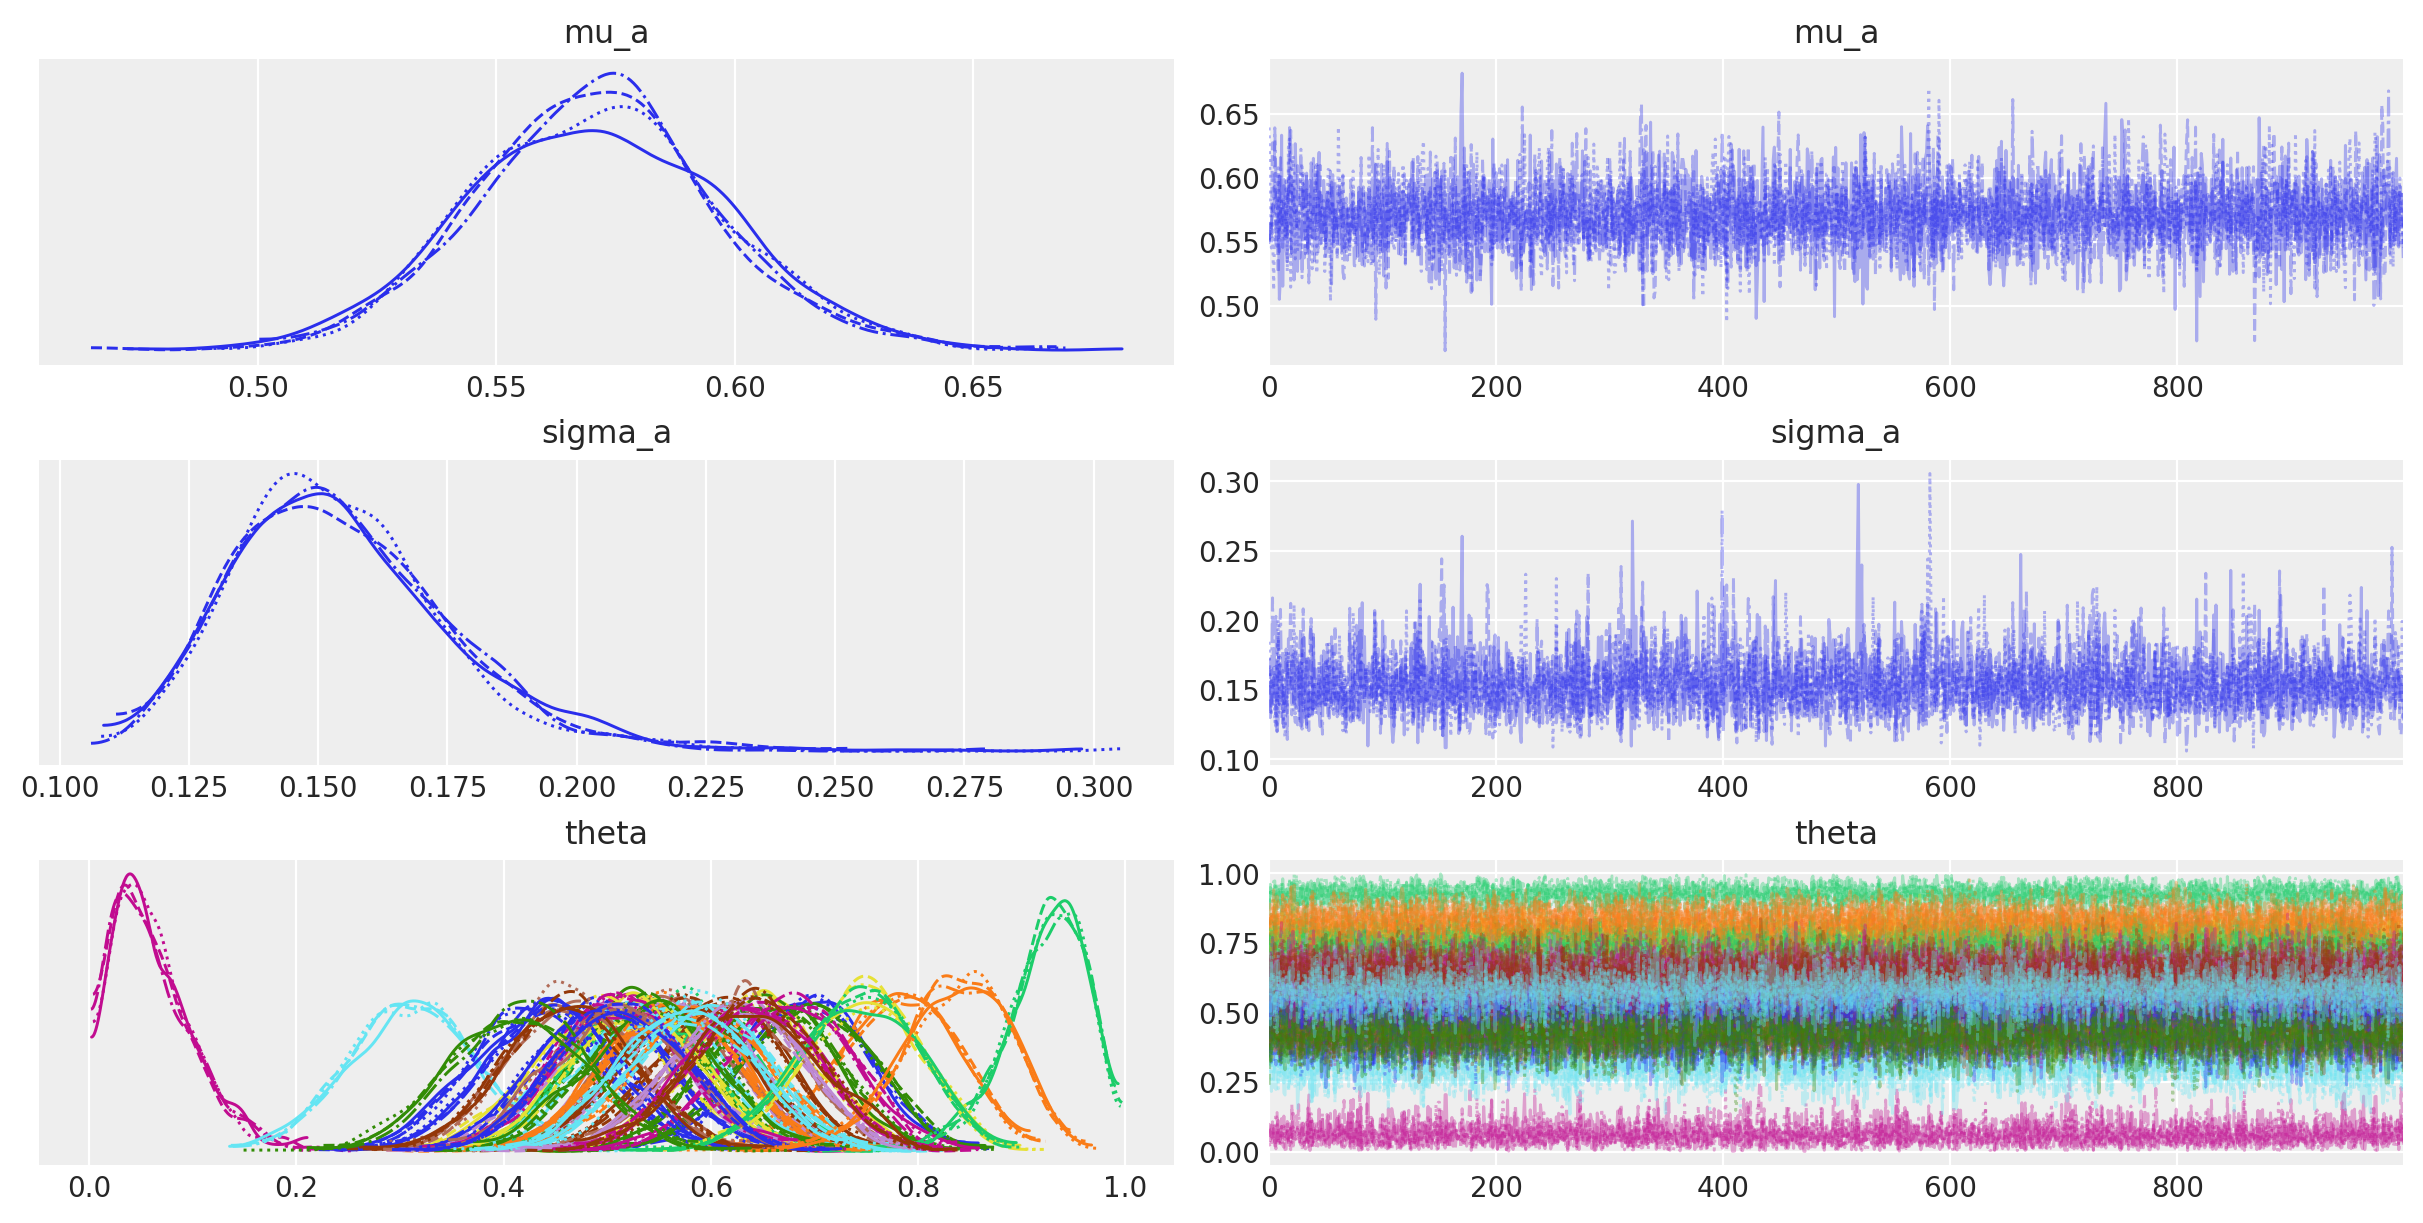

In [74]:
az.plot_trace(idata)

## Bernoulli Model

In [59]:
players = df['player'].unique().tolist()
coords = {
    "player": players
}

with pm.Model(coords=coords) as bernoulli_unpooled_model:
    # Priors for unknown model parameters
    theta = pm.Beta("theta", alpha=1, beta=1, dims="player")
    # Likelihood (sampling distribution) of observations
    decision = pm.Bernoulli(
        "decision", 
        p=theta, 
        observed=observed_decisions
    )

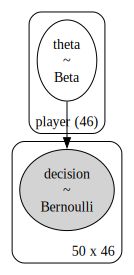

In [60]:
pm.model_to_graphviz(bernoulli_unpooled_model)

In [61]:
with bernoulli_unpooled_model:
    idata = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [62]:
az.plot_trace(idata)

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

## Hierarchical Bernoulli Model

In [76]:
players = df['player'].unique().tolist()
coords = {
    "player": players
}
threshold = 0.5

with pm.Model(coords=coords) as bernoulli_hierarchical_model:
    # Priors
    mu_a = pm.Normal("mu_a", mu=threshold, sigma=1)
    sigma_a = pm.Exponential("sigma_a", 1)
    # Random thetas
    go_probability = pm.TruncatedNormal(
        "go_probability", 
        mu=mu_a, 
        sigma=sigma_a, 
        lower=0,
        upper=1,
        dims="player"
    )
    # Likelihood (sampling distribution) of observations
    choice_obs = pm.Bernoulli("choice_obs", p=go_probability, observed=observed_decisions)

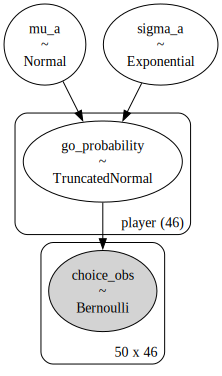

In [77]:
pm.model_to_graphviz(bernoulli_hierarchical_model)

In [65]:
with bernoulli_hierarchical_model:
    idata = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, theta]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.


array([[<Axes: title={'center': 'mu_a'}>,
        <Axes: title={'center': 'mu_a'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

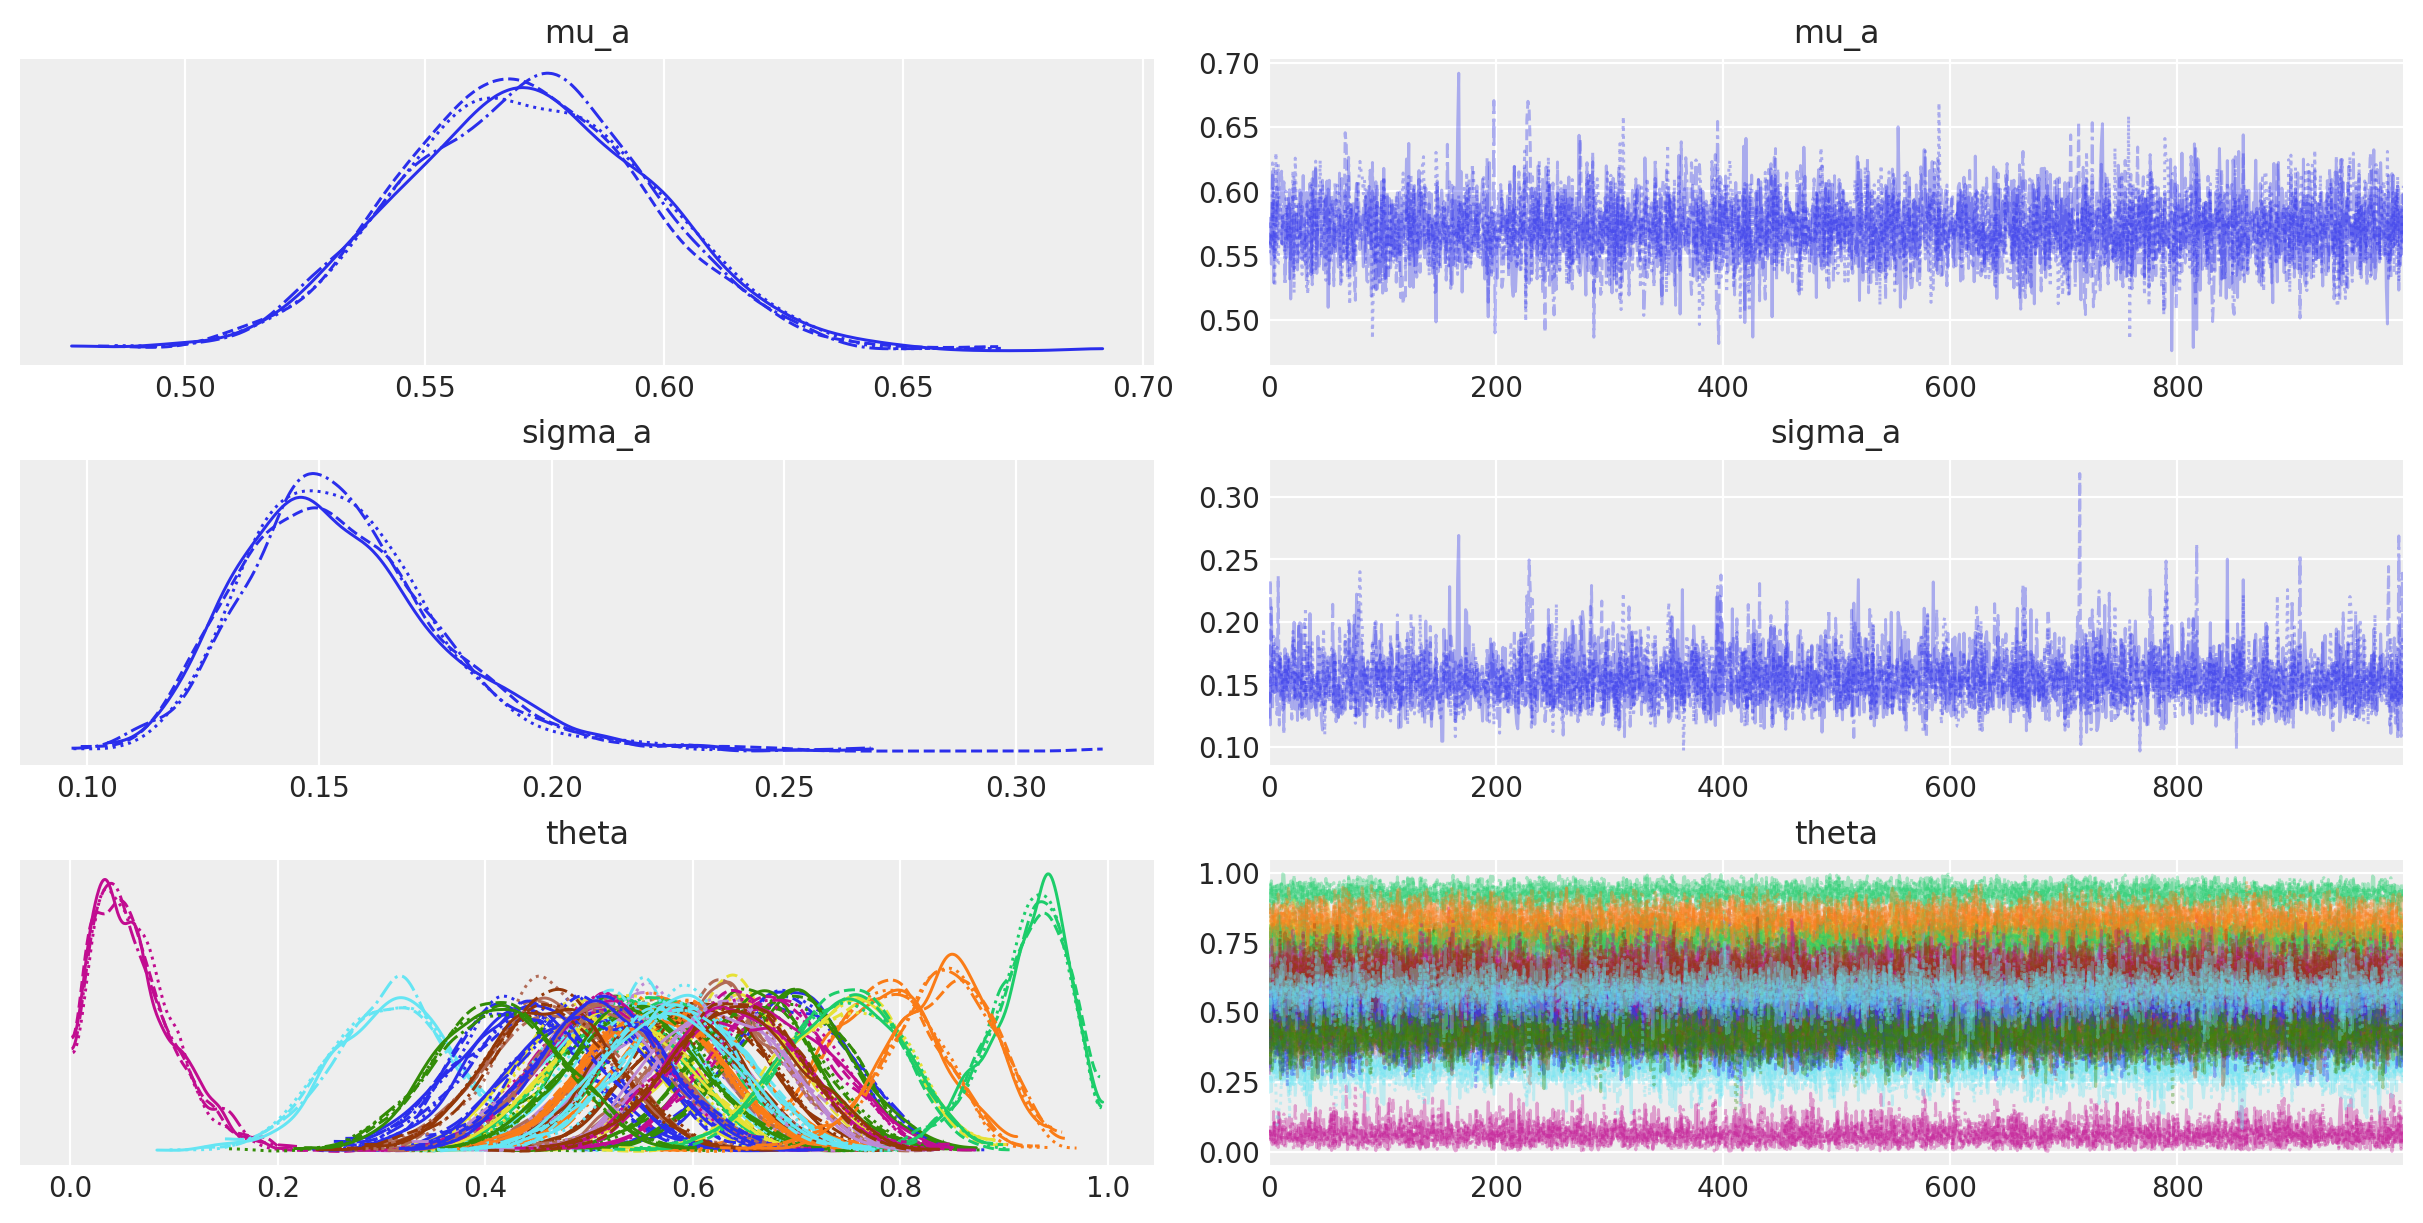

In [66]:
az.plot_trace(idata)